### OLS (Ordinary Least Squares) Varsayımlarının Sağlanması

Serinin bu bölümünde, OLS (Ordinary Least Squares) yöntemiyle yapılan modelleme işlemlerinde sağlanması gereken varsayımlar incelenmiş ve ardından elde edilen tahminlerin karşılaştırılması için çeşitli görselleştirme işlemleri gerçekleştirilmiştir.

In [1]:
# Gerekli kütüphane ve fonksiyonların kurulması

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

import yfinance as yf
import missingno as msno

from scipy import stats
import statsmodels.api as sm

from termcolor import colored
from statsmodels.stats.diagnostic import normal_ad
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import het_breuschpagan

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings("ignore")

random.seed(30)

####  1. Defining the OLS Functions

In [2]:
def OLS_assumption_controller(model, x_train_data, y_train_data):
    
    yhat = model.predict(x_train_data)
    df = pd.DataFrame({"Actual": y_train_data, "Predicted": yhat})
    df["Residuals"] = df["Actual"] - df["Predicted"]
    
    print("Kolmogorov-Simirnov Normality Test -------------------")
    p_ks = stats.kstest(df["Residuals"], "norm", args = (np.mean(df["Residuals"]), np.std(df["Residuals"])))[1]
    if p_ks < 0.05:
        print(colored("Residuals are not normally distributed", "red", attrs = ["bold"]))
    else:
        print(colored("Residuals are normally distributed", "green", attrs = ["bold"]))
    print("\n")
    
    
    print("Variance Inflation Factor for Multicollinearity Test -----")
    
    VIF = [variance_inflation_factor(x_train_data.values, i) for i in range(x_train_data.shape[1])]
    
    for idx, vif in enumerate(VIF):
        if vif < 10:
            print(colored("{0}: {1}".format(x_train_data.columns[idx], vif), "green", attrs = ["bold"]))
        else:
            print(colored("{0}: {1}".format(x_train_data.columns[idx], vif), "red", attrs = ["bold"]))
    
    print("\n")
    
    print("Durbin Watson Autocorrelation Test -----------------")
    
    durbinWatson = durbin_watson(df["Residuals"])
    
    if 1.5 < durbinWatson < 2.5:
        print(colored("There is no autocorrelation in the resiuals", "green", attrs = ["bold"]))
    else:
        print(colored("There is an autocorrelation in the resiuals", "red", attrs = ["bold"]))
              
    print("\n")
              
    
    print("Breusch-Pagan Heteroskedasticity Test ----------")
    bp_test = het_breuschpagan(df["Residuals"], x_train_data)
    if bp_test[1] < 0.05:
        print(colored("The model is heteroskedastic.", "red", attrs = ["bold"]))
    else:
        print(colored("The model is not heteroskedastic.", "green", attrs = ["bold"]))


#### 2. Data Operations

In [3]:
tickers = ["TRY=X", "EURTRY=X", "GBPTRY=X", "XU100.IS", "DAX", "GC=F", "^GSPC"]

start_date = '2015-01-01'

end_date = '2017-01-01'

panel_data = yf.download(tickers, start = start_date, end = end_date, progress = False)

df = panel_data["Close"]

df.rename(columns = {"TRY=X"    : "USD_TRY",
                     "EURTRY=X" : "EUR_TRY",
                     "GBPTRY=X" : "GDP_TRY",
                     "XU100.IS" : "BIST100",
                     "DAX"      : "DAX",
                     "GC=F"     : "GOLD",
                     "^GSPC"    : "SP500"}, inplace = True)

df.fillna(method = 'bfill', inplace = True)

df.dropna(inplace = True)

df.reset_index(inplace = True)

df.head()

Ticker,Date,DAX,EUR_TRY,GDP_TRY,GOLD,USD_TRY,BIST100,SP500
0,2015-01-01,26.163000,2.82487,3.6379,1186.000000,2.33116,85458.898438,2058.199951
1,2015-01-02,26.163000,2.81987,3.6338,1186.000000,2.33098,85458.898438,2058.199951
2,2015-01-05,24.879999,2.79728,3.5788,1203.900024,2.34224,86462.601562,2020.579956
3,2015-01-06,24.879999,2.78208,3.5559,1219.300049,2.33075,86909.601562,2002.609985
4,2015-01-07,24.879999,2.75848,3.5162,1210.599976,2.32361,86776.601562,2025.900024


In [4]:
df.shape

(522, 8)

#### 3. Linear Regression

In [5]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()

y = df["BIST100"]
x = df[["USD_TRY", "DAX", "GOLD", "SP500"]]

model_lr = model.fit(x, y)
model_lr.intercept_

print(f'Coefficients: {model_lr.coef_}')

print(f'Intercept: {model_lr.intercept_}')

print(f'R^2 Score: {model_lr.score(x, y)}')

Coefficients: [-1.40410419e+04  1.95705822e+02  4.99063206e+00  2.07073288e+01]
Intercept: 65251.7493764357
R^2 Score: 0.6798458012958984


#### 4. Train-Test Split

In [6]:
indexing = np.arange(df.shape[0] // (4/3))

x_train = x[x.index.isin(indexing)]
x_test = x[~x.index.isin(indexing)]

y_train = y[y.index.isin(indexing)]
y_test = y[~y.index.isin(indexing)]

base_model = model.fit(x_train, y_train)
base_pred =  base_model.predict(x_test)

In [7]:
rmse_base = np.sqrt(np.square(np.subtract(y_test, base_pred)).mean())

rmse_base

4379.450976064442

#### 4.1. Comparision

In [8]:
comp_data = pd.DataFrame({"Obs": y_test, "Pred": base_pred})

comp_data["Error"] = comp_data["Obs"] - comp_data["Pred"]

comp_data.head()

,Obs,Pred,Error
391,77952.101562,82476.837815,-4524.736252
392,78387.703125,82211.148520,-3823.445395
393,78019.500000,82160.484305,-4140.984305
394,78019.500000,82282.171179,-4262.671179
395,78019.500000,81955.983584,-3936.483584


#### 4.2. Box Plot

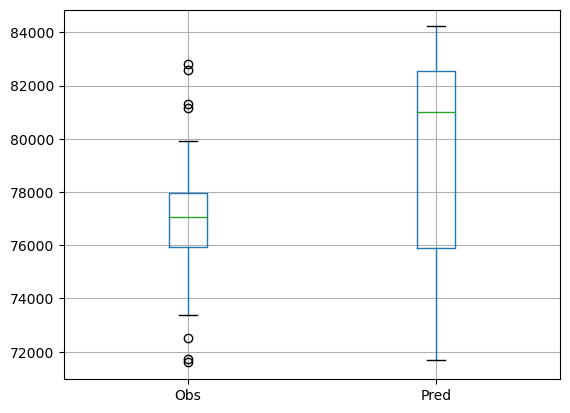

In [9]:
comp_data.boxplot(column = ["Obs", "Pred"])

plt.show()

#### 4.3. Dist Plot

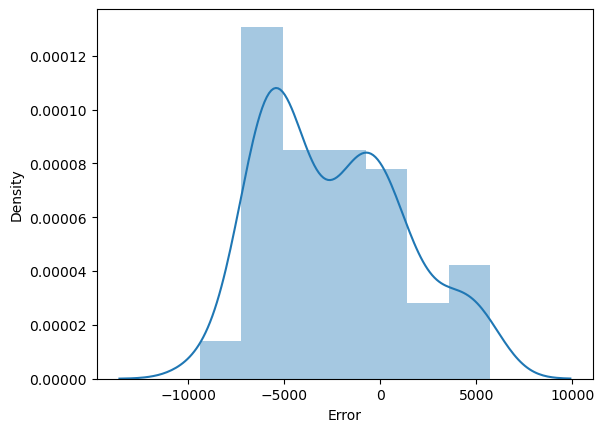

In [10]:
sns.distplot(comp_data["Error"]) # Hataların Dağılımı

plt.show()

#### 4.3.  Residual Operation

In [11]:
lower_base = np.percentile(comp_data["Error"], 10)
upper_base = np.percentile(comp_data["Error"], 90)

comp_data["Error_Class"] = [2 if v > upper_base else 1 if v < lower_base else 0 for v in comp_data["Error"]]

error_counts_base = comp_data.value_counts("Error_Class")

error_counts_base

Error_Class
0    105
1     13
2     13
dtype: int64

#### 4.4. Scatter Plot

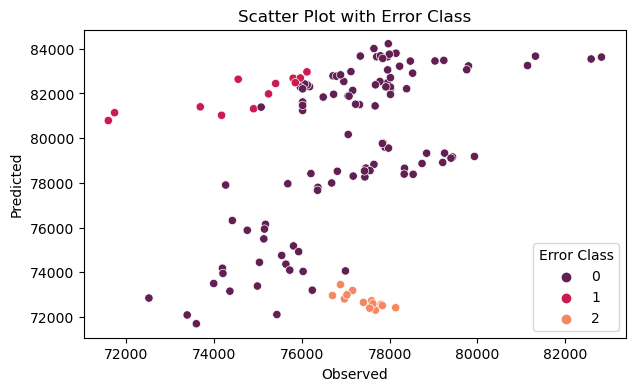

In [12]:
# Error_Class sütunu kategorik bir değişkene dönüştürüldü.

comp_data["Error_Class"] = pd.Categorical(comp_data["Error_Class"])

plt.figure(figsize = (7, 4))
sns.scatterplot(data = comp_data, x = "Obs", y = "Pred", hue = "Error_Class", palette = "rocket")
plt.xlabel("Observed")
plt.ylabel("Predicted")
plt.title("Scatter Plot with Error Class")
plt.legend(title = "Error Class")

plt.show()

#### 4.5. Assumption Control

In [13]:
base_residual = OLS_assumption_controller(base_model, x_train, y_train)

base_residual

Kolmogorov-Simirnov Normality Test -------------------
Residuals are normally distributed


Variance Inflation Factor for Multicollinearity Test -----
USD_TRY: 235.5103362650846
DAX: 623.2710200375383
GOLD: 314.8999383993905
SP500: 2087.902269583021


Durbin Watson Autocorrelation Test -----------------
There is an autocorrelation in the resiuals


Breusch-Pagan Heteroskedasticity Test ----------
The model is heteroskedastic.


In [14]:
models = {"Base Model": {"Model_Objects": ["base_model", "x_train", "y_train", "base_pred"],
          "RMSE Permonce Metric":rmse_base,
          "Error Bounds": (lower_base, upper_base),
          "Error Counts": ((0, 2, 1), list(error_counts_base)),
          "Residuals Object": "base_residuals"}}

models

{'Base Model': {'Model_Objects': ['base_model',
   'x_train',
   'y_train',
   'base_pred'],
  'RMSE Permonce Metric': 4379.450976064442,
  'Error Bounds': (-6364.7011649671185, 3317.8976388392766),
  'Error Counts': ((0, 2, 1), [105, 13, 13]),
  'Residuals Object': 'base_residuals'}}

#### 5. Taking Difference

In [15]:
x_train_diff = x_train.diff().dropna()
y_train_diff = y_train.values[1:]

x_test_diff = x_test.diff().dropna()
y_test_diff = y_test.values[1:]

model_diff = model.fit(x_train_diff, y_train_diff)
pred_diff = model_diff.predict(x_test_diff)

rmse_diff = np.sqrt(np.square(np.subtract(y_test_diff, pred_diff)).mean())

rmse_diff

3201.409961568065

#### 5.1. Comparision

In [16]:
comp_data_diff = pd.DataFrame({"Obs": y_test_diff, "Pred": pred_diff})

comp_data_diff["Error"] = comp_data_diff["Obs"] - comp_data_diff["Pred"]

comp_data_diff.head()

,Obs,Pred,Error
0,78387.703125,78001.675014,386.028111
1,78019.500000,79518.982591,-1499.482591
2,78019.500000,79041.580010,-1022.080010
3,78019.500000,79300.817628,-1281.317628
4,78019.500000,80295.231751,-2275.731751


#### 5.2. Box Plot

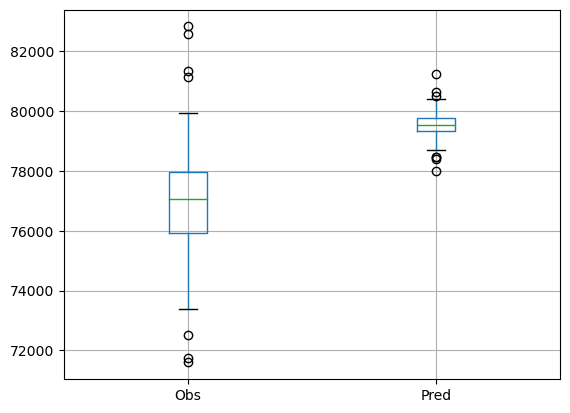

In [17]:
comp_data_diff.boxplot(column = ["Obs", "Pred"])

plt.show()

#### 5.3. Dist Plot

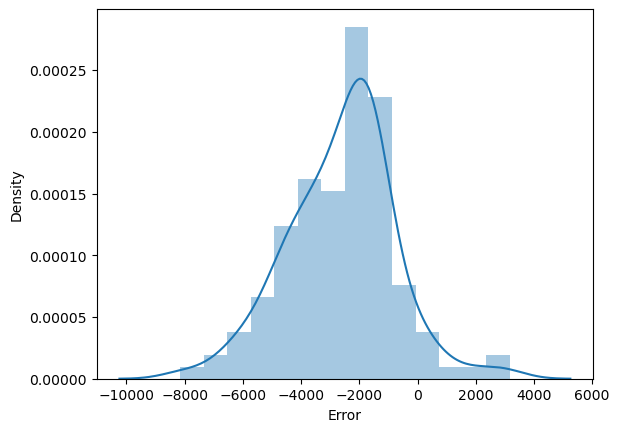

In [18]:
sns.distplot(comp_data_diff["Error"])

plt.show()

#### 5.4. Residual Operation

In [19]:
lower_diff = np.percentile(comp_data_diff["Error"], 10)
upper_diff = np.percentile(comp_data_diff["Error"], 90)

comp_data_diff["Error_Class"] = [2 if v > upper_diff else 1 if v < lower_diff else 0 for v in comp_data_diff["Error"]]

error_counts_diff = comp_data_diff.value_counts("Error_Class")

error_counts_diff

Error_Class
0    104
1     13
2     13
dtype: int64

#### 5.5. Scatter Plot

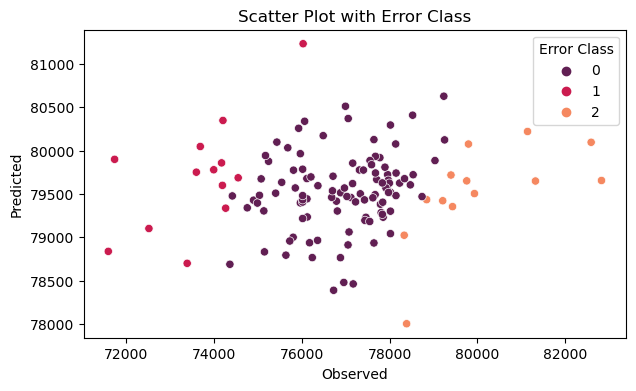

In [20]:
# Error_Class sütunu kategorik bir değişkene dönüştürüldü.

comp_data_diff["Error_Class"] = pd.Categorical(comp_data_diff["Error_Class"])

plt.figure(figsize = (7, 4))
sns.scatterplot(data = comp_data_diff, x = "Obs", y = "Pred", hue = "Error_Class", palette = "rocket")
plt.xlabel("Observed")
plt.ylabel("Predicted")
plt.title("Scatter Plot with Error Class")
plt.legend(title = "Error Class")

plt.show()

#### 5.6. Assumption Control

In [21]:
residual_diff = OLS_assumption_controller(model_diff, x_train_diff, y_train_diff)

residual_diff

Kolmogorov-Simirnov Normality Test -------------------
Residuals are normally distributed


Variance Inflation Factor for Multicollinearity Test -----
USD_TRY: 1.0168967136677756
DAX: 1.9651432735476435
GOLD: 1.045428382683689
SP500: 1.9839833956091026


Durbin Watson Autocorrelation Test -----------------
There is an autocorrelation in the resiuals


Breusch-Pagan Heteroskedasticity Test ----------
The model is not heteroskedastic.


In [22]:
catch_error = pd.DataFrame({"test_y": y_test[1:],
                            "base_data": comp_data["Error_Class"].values[1:],
                            "diff_data": comp_data_diff['Error_Class'].values,
                            "order": np.arange(1, y_test.shape[0])})

catch_error

,test_y,base_data,diff_data,order
392,78387.703125,0,2,1
393,78019.500000,0,0,2
394,78019.500000,0,0,3
395,78019.500000,0,0,4
396,78019.500000,0,0,5
...,...,...,...,...
517,77028.500000,2,0,126
518,76699.398438,2,0,127
519,77547.703125,2,0,128
520,77835.898438,2,0,129


In [23]:
models.update({"Diff Model": {"Model_Objects": ["model_diff", "x_train_diff", "y_train_diff", "pred_diff"],
          "RMSE Permonce Metric": rmse_diff,
          "Error Bounds": (lower_diff, upper_diff),
          "Error Counts": ((0, 2, 1), list(error_counts_diff)),
          "Residuals Object": "residual_diff"}})

models

{'Base Model': {'Model_Objects': ['base_model',
   'x_train',
   'y_train',
   'base_pred'],
  'RMSE Permonce Metric': 4379.450976064442,
  'Error Bounds': (-6364.7011649671185, 3317.8976388392766),
  'Error Counts': ((0, 2, 1), [105, 13, 13]),
  'Residuals Object': 'base_residuals'},
 'Diff Model': {'Model_Objects': ['model_diff',
   'x_train_diff',
   'y_train_diff',
   'pred_diff'],
  'RMSE Permonce Metric': 3201.409961568065,
  'Error Bounds': (-5058.701589730178, -726.1903374601327),
  'Error Counts': ((0, 2, 1), [104, 13, 13]),
  'Residuals Object': 'residual_diff'}}

#### 6. OLS Varsayımları | MinMax Scaling, Rate of Return

x_scaled = (x - x_min) / (x_max - x_min)

In [24]:
scaler = MinMaxScaler()

scaled = scaler.fit_transform(x)

x_scaled = pd.DataFrame(scaled)

x_scaled.rename({0: "USD_TRY",
                 1: "DAX",
                 2: "GOLD",
                 3: "SP500"}, axis = 1, inplace = True)

x_scaled.head()

,USD_TRY,DAX,GOLD,SP500
0,0.039599,0.631975,0.430436,0.517622
1,0.039457,0.631975,0.430436,0.517622
2,0.048385,0.459459,0.487424,0.432631
3,0.039274,0.459459,0.536453,0.392034
4,0.033613,0.459459,0.508755,0.444650


In [25]:
x_train_MM = x_scaled[x_scaled.index.isin(indexing)]
x_test_MM = x_scaled[~x_scaled.index.isin(indexing)]

y_train_MM = y_train
y_test_MM = y_test

model_MM = model.fit(x_train_MM, y_train_MM)
pred_MM = model_MM.predict(x_test_MM)

RMSE_MM = np.sqrt(np.square(np.subtract(y_test_MM, pred_MM)).mean())

RMSE_MM

4379.450976064451

#### 6.1. Comparision

In [26]:
comp_data_MM = pd.DataFrame({"Obs": y_test_MM, "Pred": pred_MM})

comp_data_MM["Error"] = comp_data_MM["Obs"] - comp_data_MM["Pred"]

comp_data_MM.head()

,Obs,Pred,Error
391,77952.101562,82476.837815,-4524.736252
392,78387.703125,82211.148520,-3823.445395
393,78019.500000,82160.484305,-4140.984305
394,78019.500000,82282.171179,-4262.671179
395,78019.500000,81955.983584,-3936.483584


#### 6.2. Dist Plot

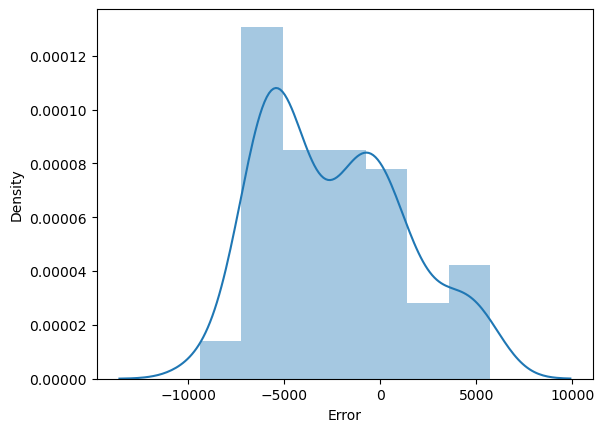

In [27]:
sns.distplot(comp_data_MM["Error"])

plt.show()

#### 6.3. Residual Operation

In [28]:
lower_MM = np.percentile(comp_data_MM["Error"], 10)
upper_MM = np.percentile(comp_data_MM["Error"], 90)

comp_data_MM["Error_Class"] = [2 if v > upper_MM else 1 if v < lower_MM else 0 for v in comp_data_MM["Error"]]

error_counts_MM = comp_data_MM.value_counts("Error_Class")

error_counts_MM

Error_Class
0    105
1     13
2     13
dtype: int64

#### 6.4. Scatter Plot

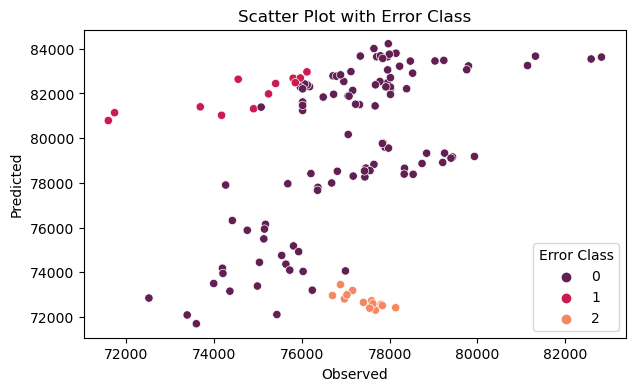

In [29]:
# Error_Class sütunu kategorik bir değişkene dönüştürüldü.

comp_data_MM["Error_Class"] = pd.Categorical(comp_data_MM["Error_Class"])

plt.figure(figsize = (7, 4))
sns.scatterplot(data = comp_data_MM, x = "Obs", y = "Pred", hue = "Error_Class", palette = "rocket")
plt.xlabel("Observed")
plt.ylabel("Predicted")
plt.title("Scatter Plot with Error Class")
plt.legend(title = "Error Class")

plt.show()

#### 6.5. Assumption Control

In [30]:
residual_MM = OLS_assumption_controller(model_MM, x_train_MM, y_train_MM)

residual_MM

Kolmogorov-Simirnov Normality Test -------------------
Residuals are normally distributed


Variance Inflation Factor for Multicollinearity Test -----
USD_TRY: 4.35814066585546
DAX: 13.650672081983842
GOLD: 4.361844813211167
SP500: 26.89111219604334


Durbin Watson Autocorrelation Test -----------------
There is an autocorrelation in the resiuals


Breusch-Pagan Heteroskedasticity Test ----------
The model is heteroskedastic.


#### 6.6. Box Plot

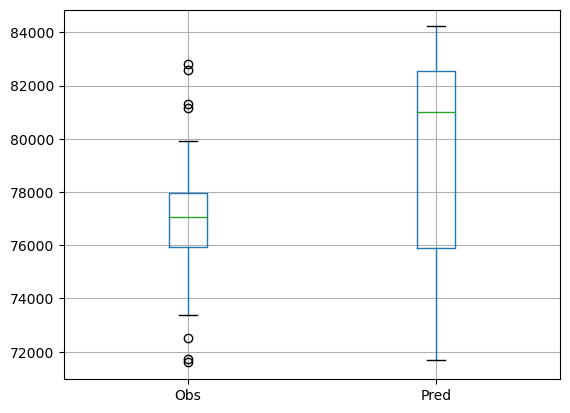

In [31]:
comp_data_MM.boxplot(column = ["Obs", "Pred"])

plt.show()

In [32]:
models.update({"MinMax Model": {"Model_Objects": ["model_MM", "x_train_MM", "y_train_MM", "pred_MM"],
              "RMSE Permonce Metric": RMSE_MM,
              "Error Bounds": (lower_MM, upper_MM),
              "Error Counts": ((0, 2, 1), list(error_counts_MM)),
              "Residuals Object": "residual_MM"}})

models

{'Base Model': {'Model_Objects': ['base_model',
   'x_train',
   'y_train',
   'base_pred'],
  'RMSE Permonce Metric': 4379.450976064442,
  'Error Bounds': (-6364.7011649671185, 3317.8976388392766),
  'Error Counts': ((0, 2, 1), [105, 13, 13]),
  'Residuals Object': 'base_residuals'},
 'Diff Model': {'Model_Objects': ['model_diff',
   'x_train_diff',
   'y_train_diff',
   'pred_diff'],
  'RMSE Permonce Metric': 3201.409961568065,
  'Error Bounds': (-5058.701589730178, -726.1903374601327),
  'Error Counts': ((0, 2, 1), [104, 13, 13]),
  'Residuals Object': 'residual_diff'},
 'MinMax Model': {'Model_Objects': ['model_MM',
   'x_train_MM',
   'y_train_MM',
   'pred_MM'],
  'RMSE Permonce Metric': 4379.450976064451,
  'Error Bounds': (-6364.7011649671185, 3317.8976388393203),
  'Error Counts': ((0, 2, 1), [105, 13, 13]),
  'Residuals Object': 'residual_MM'}}

#### 7. Rate of Return Calculation

In [33]:
x_train_ror = x_train_diff
x_test_ror = x_test_diff

y_train_ror = y_train.pct_change().dropna()
y_test_ror = y_test.pct_change().dropna()

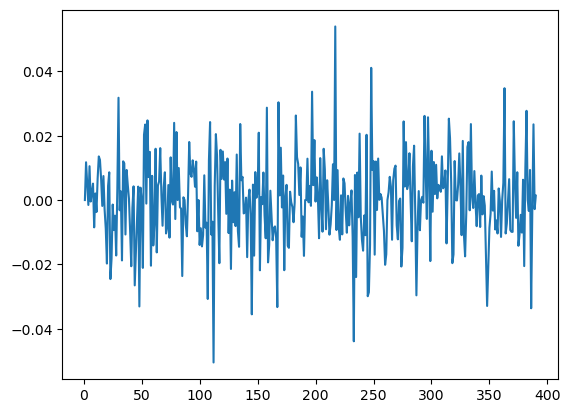

In [34]:
y_train_ror.plot()

plt.show()

In [35]:
model_ror = model.fit(x_train_ror, y_train_ror)
pred_ror = model_ror.predict(x_test_ror)

#### 7.1. Comparision

In [36]:
comp_data_ror = pd.DataFrame({"Obs": y_test_ror, "Pred": pred_ror})

comp_data_ror["Error"] = comp_data_ror["Obs"] - comp_data_ror["Pred"]

comp_data_ror.head()

,Obs,Pred,Error
392,0.005588,-0.009006,0.014594
393,-0.004697,-0.000280,-0.004417
394,0.000000,-0.000661,0.000661
395,0.000000,-0.003151,0.003151
396,0.000000,0.008077,-0.008077


#### 7.2. Dist Plot

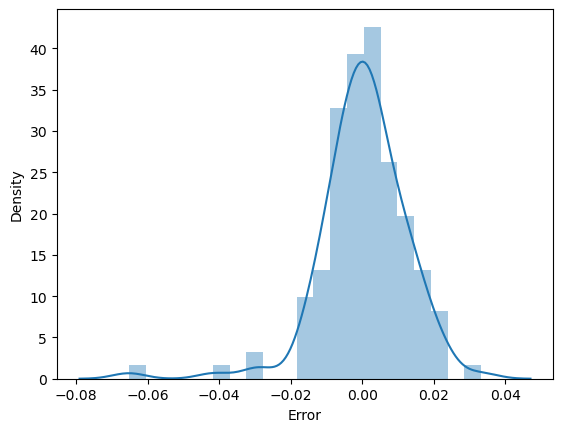

In [37]:
sns.distplot(comp_data_ror["Error"])

plt.show()

#### 7.3. Residual Operation

In [38]:
lower_ror = np.percentile(comp_data_ror["Error"], 10)
upper_ror = np.percentile(comp_data_ror["Error"], 90)

comp_base_ror = comp_data["Error"].pct_change().dropna()

lower_base_ror = np.percentile(comp_base_ror.values, 10)
upper_base_ror = np.percentile(comp_base_ror.values, 90)

comp_data_ror["Error_Class"] = [2 if v > upper_base_ror else 1 if v < lower_base_ror else 0 for v in comp_data_ror["Error"]]

error_counts_ror = comp_data_ror.value_counts("Error_Class")

error_counts_ror

Error_Class
0    130
dtype: int64

#### 7.4. Box Plot

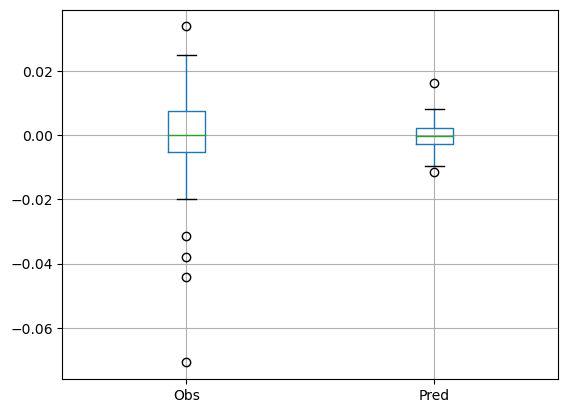

In [39]:
comp_data_ror.boxplot(column = ["Obs", "Pred"])

plt.show()

#### 7.5. Scatter Plot

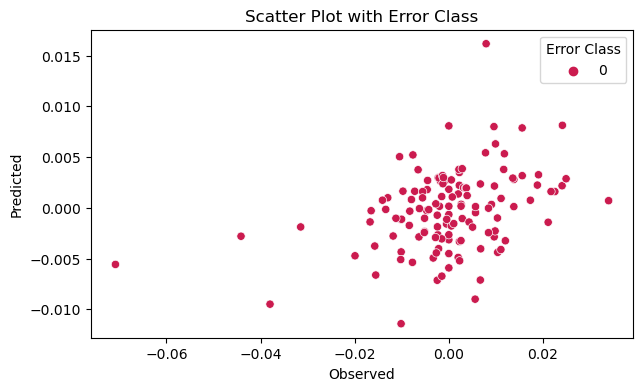

In [40]:
# Error_Class sütunu kategorik bir değişkene dönüştürüldü.

comp_data_ror["Error_Class"] = pd.Categorical(comp_data_ror["Error_Class"])

plt.figure(figsize = (7, 4))
sns.scatterplot(data = comp_data_ror, x = "Obs", y = "Pred", hue = "Error_Class", palette = "rocket")
plt.xlabel("Observed")
plt.ylabel("Predicted")
plt.title("Scatter Plot with Error Class")
plt.legend(title = "Error Class")

plt.show()

#### 7.6. Assumption Control

In [41]:
residual_ror = OLS_assumption_controller(model_ror, x_train_ror, y_train_ror)

residual_ror

Kolmogorov-Simirnov Normality Test -------------------
Residuals are normally distributed


Variance Inflation Factor for Multicollinearity Test -----
USD_TRY: 1.0168967136677756
DAX: 1.9651432735476435
GOLD: 1.045428382683689
SP500: 1.9839833956091026


Durbin Watson Autocorrelation Test -----------------
There is no autocorrelation in the resiuals


Breusch-Pagan Heteroskedasticity Test ----------
The model is not heteroskedastic.


#### KAYNAKLAR

[1] Mustafa Nayansak, Veri Bilimi Okulu, Python ile Finansal Veri Analizi: